# Decision Trees - Classification

**Installation**:  You will need to install python and jupyter.  The easiest way is to install the package `Anaconda` as follows. 

- Download Anaconda from [this link](https://www.anaconda.com/download)
- Install Anaconda from the downloaded file
- Open Jupyter Lab by 

    - (1) Click to the Start Windows Logo and Type in Anconda Promp.  Open Anaconda Promp
    - (2) In Anaconda Promp, type in: `jupyter lab` and hit Enter
 
 
 
- Install the `graphviz` package
    - Open Anaconda Prompt. 
    - Type in: `conda install python-graphviz`

**Data**: The data should be in the same folder as the notebook.


# 1. An example of training a decision tree

We will go over the above steps to train decision tree with the `titanic` dataset. Notice that these codes can be reused for other dataset. The codes for Step 1, 4, 5, 6, and 7 should be the same or at least similar when applied to other data.  Only Step 2 and Step 3 will be different from data to data. 

### Step 1: Import and Clean Data

In [1]:
# import some packages
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

In [2]:
# Import the data
df = pd.read_csv('titanic.csv')

In [3]:
# Check the variables
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Assign the input and output variable

In [4]:
# Assign input variables
X = df.loc[:,['Pclass','Sex','Age','Fare','Embarked','SibSp','Parch']]

# Assign target variable
y = df['Survived']

#### Check and fix variable types

In [5]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
Fare        float64
Embarked     object
SibSp         int64
Parch         int64
dtype: object

In [6]:
# Change Pclass to categorical variable
X['Pclass'] = X['Pclass'].astype(object)

### Step 2: Check and handle missing values

In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Replace missing values by the median
X["Age"] = X["Age"].fillna(X["Age"].median())

# Impute the Embarked variable
X["Embarked"] = X["Embarked"].fillna("S")

### Step 3: Encode Categorical Variables

`sklearn` does not work directly with categorical variables. It requires the categorical variables to be encoded into numeric variables. There are multiple way to encode categorical variables.  Here, we implement the simplest way of encoding: `one-hot` encoding or `dummy` encoding. 

In [9]:
# Encode categorical variable
X = pd.get_dummies(X)

### Step 4: Split the data into training and testing

In [10]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

### Step 5: Train a model

In [11]:
# Create a decision tree and train
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=3)
tree1.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

#### Plot the tree

In [12]:
# conda install graphviz

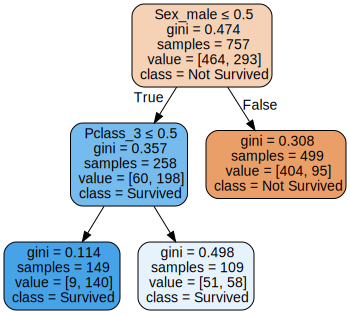

In [13]:
from sklearn import tree

import graphviz 

dot_data = tree.export_graphviz(tree1, out_file=None) 
dot_data = tree.export_graphviz(tree1, out_file=None, 
                     feature_names=x_train.columns,  
                     class_names=['Not Survived','Survived'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

graph = graphviz.Source(dot_data)  

graph

### Step 6: Test the model

#### Confusion Matrix

In [14]:
ypred_test = tree1.predict(x_test)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ypred_test, y_test)
print('===============')
print('Confusion Matrix:')
print(mat)
print('===============')
print('Testing Accuracy:')
print(mat.diagonal().sum()/mat.sum())
print('===============')

Confusion Matrix:
[[64 14]
 [21 35]]
Testing Accuracy:
0.7388059701492538


#### Testing Accuracy

In [15]:
# Prediction and accuracy on testing data

print('Testing Accuracy is:')
tree1.score(x_test, y_test)

Testing Accuracy is:


0.7388059701492538

### Step 7: Hyperparameters Tuning and redo Step 5 and 6
How do we know the selection of `max_leaf_nodes` and `criterion` in Step 5 is the best selection?

Tuning hyperparameters or Tuning a model is to search for the set of hyperparameters that works the best.  To tune a model, one first needs to know what the hyperparameters/tuning parameters that the model has. A model may have several hyperparamters that sometime it is not practical to tune all the hyperparameters. 

Our model here is decision tree. To see the list of tuning parameters of decision trees, one can check at the `sklearn` document of the model. One way to find out is to `google`: DecisionTreeClassifier and sklearn.  This search brings us to [this link.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

From the link, you can see the list of (hyper)parameters. In this example, we will tune two parameters `max_leaf_nodes` and `criterion`. 

In [16]:
import warnings
warnings.filterwarnings("ignore")


# Decide what hyperparameter to tune then decide the searching range
param_grid = {'max_leaf_nodes': range(2,10), 
              'criterion':['gini', 'entropy']}

# Create a list of trees
from sklearn.model_selection import GridSearchCV
tree2 = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': range(2, 10)})

In the above code, `cv=5` means the cross validation is done with 5 folds.  This means that the training data will be partition into 5 pieces and each piece will be used as a validation data while the remaining four pieces will be used as the data to build model. 

More informatiom about `k-fold cross validation` can be seen [here](https://bryantstats.github.io/overfitting.html#/50) 

In this example, with 10 different values of `max_leaf_nodes` (2 to 9), and 2 different values of `criterion`, there will be 8x2=16 models (trees) will be tested. Each of these 16 models will be run 5 times (since `cv=5`). Thus, in total, there will be 16x5=80 times a tree is computed. The search for the best parameters could be time consuming! 

In [17]:
cv_result = pd.concat([pd.DataFrame(tree2.cv_results_["params"]),pd.DataFrame(tree2.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
cv_result['Rank'] = (-cv_result['Accuracy']).argsort().argsort()
cv_result

,criterion,max_leaf_nodes,Accuracy,Rank
0,gini,2,0.795268,12
1,gini,3,0.795268,13
2,gini,4,0.796593,10
3,gini,5,0.805838,8
4,gini,6,0.808496,7
5,gini,7,0.819092,2
6,gini,8,0.823048,0
7,gini,9,0.823048,1
8,entropy,2,0.795268,14
9,entropy,3,0.795268,15


The above shows that the best hyperparameters are criterion=entropy and max_leaf_nodes=7. We can use this information to redo step 5. 

Best Tree is: {'criterion': 'gini', 'max_leaf_nodes': 8}



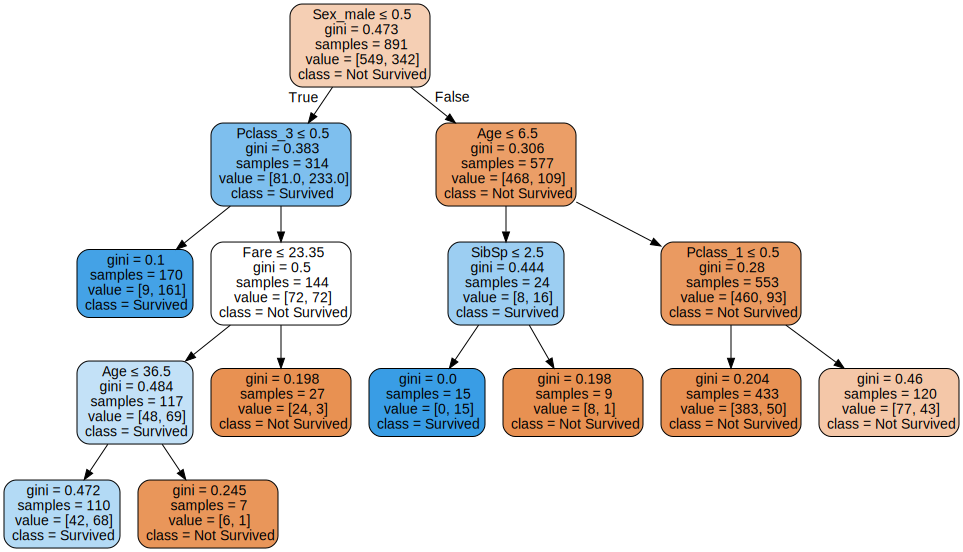

In [18]:
tree3 = DecisionTreeClassifier(**tree2.best_params_)

# Train with the selected hyperparameter
tree3.fit(X, y)

print('Best Tree is:', tree2.best_params_)
print('')
import graphviz 
dot_data = tree.export_graphviz(tree3, out_file=None) 
dot_data = tree.export_graphviz(tree3, out_file=None, 
                     feature_names=x_train.columns,  
                     class_names=['Not Survived','Survived'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

graph = graphviz.Source(dot_data)  

graph

### Step 8.  Submit predictions to Kaggle

In [19]:
# Import the test dataset and do some cleaning
df_test = pd.read_csv('titanic_test.csv')

# Assign input variables
X_test = df_test.loc[:,['Pclass','Sex','Age','Fare','Embarked','SibSp','Parch']]

# Replace missing values by the median
X_test["Age"] = X_test["Age"].fillna(X_test["Age"].median())

# Replace missing values by the median
X_test["Fare"] = X_test["Fare"].fillna(X_test["Fare"].median())

# Impute the Embarked variable
X_test["Embarked"] = X_test["Embarked"].fillna("S")
# Change Pclass to categorical variable
X_test['Pclass'] = X_test['Pclass'].astype(object)

# Encode categorical variable
X_test = pd.get_dummies(X_test)

# Make predictions
predictions = tree3.predict(X_test)

# Save the file in the same folder
submission = pd.DataFrame({'PassengerID': df_test['PassengerId'], 'Survived': predictions})
pd.DataFrame(submission).to_csv("titanic_submission.csv", index=False)

# 2. Overfitting in Decision Trees

## Training Accuracy vs. Testing Accuracy

We analyze the accuracy of Decision Tree when the spliting criterion and the number of leaves (`max_leaf_nodes`) change.  These two parameters are also called hyper-parameters or tuning parameters. 

The following plot shows that the training accuracy will increase when the number of leaves (`max_leaf_nodes`) increase. The testing accuracy increases at the beginning and decreases or isolating in the long run. 

The next plot shows that the selection of criterion also impact model performance.

In [20]:
criterion = ['entropy', 'gini']
max_leaf_nodes = range(2, 200)

#erros_plot = function(criterion, )

rs = pd.DataFrame(columns = ['Criterion','Leaves', 'Data','Accuracy'])

for criterion1 in criterion:
    for max_leaf_nodes1 in max_leaf_nodes:
        tree1 = DecisionTreeClassifier(criterion=criterion1, max_leaf_nodes=max_leaf_nodes1)
        tree1.fit(x_train, y_train)
        new_row={'Criterion':criterion1,'Leaves':max_leaf_nodes1, 'Data':'Train','Accuracy':tree1.score(x_train, y_train)}
        
        rs = pd.concat([rs, pd.DataFrame([new_row])], ignore_index=True)


        new_row={'Criterion':criterion1,'Leaves':max_leaf_nodes1, 'Data':'Test','Accuracy':tree1.score(x_test, y_test)}
        rs = pd.concat([rs, pd.DataFrame([new_row])], ignore_index=True)

<Axes: xlabel='Leaves', ylabel='Accuracy'>

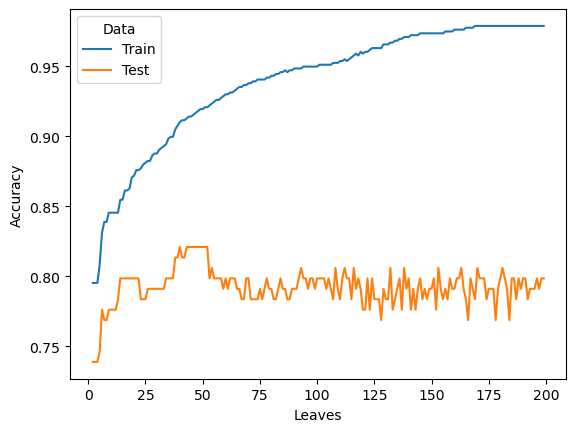

In [21]:
# Plot the training and testing accuracy of the model when criterion = gini
import seaborn as sns
rs_gini = rs[rs['Criterion']=='gini']
sns.lineplot(data=rs_gini, y="Accuracy", x="Leaves", hue='Data', ci=None)

<Axes: xlabel='Leaves', ylabel='Accuracy'>

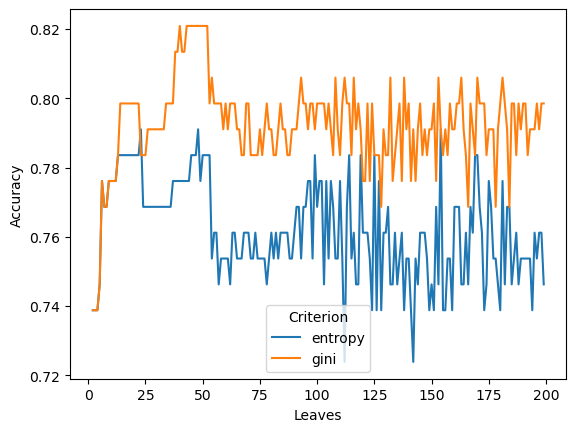

In [22]:
# Compare the impact of the criterion on tetsing accuracy
sns.lineplot(data=rs[rs['Data']=='Test'], y="Accuracy", x="Leaves", hue='Criterion')     

# 3. Practice 

Following the sample codes at this link to do/answer the below.

- Import the breast cancer dataset.  The data can be downloaded at [this link](https://bryantstats.github.io/math460/data/breast_cancer.csv)
- Check out the missing values in each columns
- Set the input (X) and output (y). Split the data into 80% training and 20% testing
- Train a decison tree with the max leaves of 4 using `entropy` as the criteria for spliting
- Calculate the testing error of the above tree
- Search for the best hyperparameters of decision where the max leaves runs from 3 to 12 and the criteria runs between `gini` and `entropy`
- What are the best hyperparameters found after the search
- Train a decision tree using the best hyperparameters.
- (Optional) Plot the tree above.
- Export the notebook: File -> Export Notebook As -> Export Notebook to html. 